In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import statsmodels.api as stm
import statsmodels
import arch.data.frenchdata
import matplotlib.pyplot as plt
from arch.unitroot import VarianceRatio
from hurst import compute_Hc, random_walk

In [5]:
%load_ext rpy2.ipython
%R install.packages("randtests")
%R library(randtests)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


R[write to console]: Warning:
R[write to console]:  unable to access index for repository https://cran.stat.unipd.it/src/contrib:
  cannot open URL 'https://cran.stat.unipd.it/src/contrib/PACKAGES'

R[write to console]: Warning:
R[write to console]:  unable to access index for repository https://cran.stat.unipd.it/bin/macosx/el-capitan/contrib/3.6:
  cannot open URL 'https://cran.stat.unipd.it/bin/macosx/el-capitan/contrib/3.6/PACKAGES'



<rpy2.robjects.vectors.StrVector object at 0x1237e0800> [RTYPES.STRSXP]
R classes: ('character',)
['randtests', 'tools', 'stats', 'graphics', ..., 'utils', 'datasets', 'methods', 'base']

## Tests used for testing EMH

In [45]:
def lung_box(returns):
   return stm.stats.diagnostic.acorr_ljungbox(returns, lags=[10], boxpierce=False)

def runs_test(returns):
  ret= pd.Series.to_numpy(returns)
  return statsmodels.sandbox.stats.runs.runstest_1samp(ret, cutoff='median', correction= True)

def hurst_exponent(returns):
  return compute_Hc(returns, kind= 'random_walk', simplified=True)

def bds(returns):
  return statsmodels.tsa.stattools.bds(returns, max_dim=2, epsilon=None, distance=1.5)

## P-value calculation using a rolling window

In [46]:
def RollingWindows(all_returns, rollingWindow):
  df = pd.DataFrame()
  for i in range (rollingWindow,len(all_returns)):
      returns = all_returns[i-rollingWindow:i]
      pvalue = []
      pvalue.append((lung_box(returns)[1]).item(0))
      pvalue.append(runs_test(returns)[1])
      pvalue.append(VarianceRatio(returns, 100).pvalue)
      pvalue.append((bds(returns)[1]).item(0))
      pvalue.append(hurst_exponent(returns)[0])
      %Rpush returns
      %R bartels = bartels.rank.test(returns, alternative= 'two.sided', pvalue='normal')
      bartels = %Rget bartels
      bartelsValue = bartels[5]
      pvalue.append(bartelsValue[0])
      x = pd.Series(pvalue)
      df = df.append(x,ignore_index=True)
  return df

## Crypto efficiency testing function

In [47]:
def CryptoEfficiency2(df,rollingWindow_size,excelName):
  writer = pd.ExcelWriter(excelName,engine='xlsxwriter')
  for i in range (0,len(df.sheet_names)):
    df_sheet = df.parse(i)
    all_returns = np.log(df_sheet['Close']).diff().dropna()
    dff = RollingWindows(all_returns,rollingWindow_size)
    dff = dff.rename(columns = {0:'Ljung-Box',1:'RunsTest', 2:'VarianceRatio', 3: 'BDSTest', 4:'HurstExponent', 5:'BartelsTest'})
    dff.to_excel(writer,sheet_name=str(df.sheet_names[i]), index= False)
    print(df.sheet_names[i],' processed ', i+1,'/',len(df.sheet_names))
  writer.save()
  print('Saved as: ',excelName)

## Plot functions

In [53]:
#single plot
def PlotTables(data):
  fig, axs = plt.subplots(1,2)
  data['Ljung-Box'].plot(xlabel= 'Rolling window= 250', ylabel= "P-value", figsize=(17,6), title= 'P-value Ljung Box Dynamic',ax=axs[0])
  data['RunsTest'].plot(xlabel= 'Rolling window = 250', ylabel= "P-value", figsize=(17,6), title= 'P-value Runs Test Dynamic',ax=axs[1])
  plt.show()
  fig, axs = plt.subplots(1,2)
  data['VarianceRatio'].plot(xlabel= 'Rolling window= 250', ylabel= "P-value", figsize=(17,6), title= 'P-value Variance Ratio Dynamic',ax=axs[0])
  data['BartelsTest'].plot(xlabel= 'Rolling window= 250', ylabel= "P-value", figsize=(17,6), title= 'P-value Bartels Test Dynamic',ax=axs[1])
  plt.show()
  data['BDSTest'].plot(xlabel= 'Rollling window= 250', ylabel= 'P-value', figsize=(17,6), title= 'P-value BDS Test Dynamic')
  plt.show()
  data['HurstExponent'].plot(xlabel= 'Rolling window= 250', ylabel= "Hurst Exponent", figsize=(17,6), title= 'Hurst Exponent Dynamic')
  plt.show()

#overlapping plots
def PlotTables2(data):
  data['Ljung-Box'].plot(xlabel= 'Rolling window= 250', ylabel= "P-value", figsize=(6,4),label='Ljung')
  data['VarianceRatio'].plot(xlabel= 'Rolling window= 250', ylabel= "P-value", figsize=(6,4),label='Variance')
  plt.legend()
  plt.show()
  data['RunsTest'].plot(xlabel= 'Rolling window = 250', ylabel= "P-value", figsize=(6,4),label='Runs')
  data['BartelsTest'].plot(xlabel= 'Rolling window= 250', ylabel= "P-value", figsize=(6,4),label='Bartels')
  plt.legend()
  plt.show()
  data['BDSTest'].plot(xlabel= 'Rolling window = 250', ylabel= "P-value", figsize=(6,4),label='BDS')
  plt.legend()
  plt.show()
  data['HurstExponent'].plot(xlabel= 'Rolling window= 250', ylabel= "Hurst Exponent", figsize=(12,4), title= 'Hurst Exponent Dynamic')
  plt.legend()
  plt.show()

#cases
def PrintTablesForExcel(data,j):
  for i in range (0,len(data.sheet_names)):
    df_sheet = data.parse(i)
    if df_sheet.empty:
      continue
    else:
      print(data.sheet_names[i])
      if(j == 1):
        PlotTables(df_sheet)
      else: PlotTables2(df_sheet)
      print('-------------------------------------')

#plot function
def AllTables(df,rollWindow,excelName,i):
  CryptoEfficiency2(df, rollWindow,excelName)
  data= pd.ExcelFile(excelName)
  PrintTablesForExcel(data,i)

BITFINEX_BTC  processed  1 / 34
COINBASE_BTC  processed  2 / 34
COINBASE_ETH  processed  3 / 34
BITFINEX_ETH  processed  4 / 34
BITFINEX_XRP  processed  5 / 34
BITSTAMP_XRP  processed  6 / 34
BITFINEX_BCH  processed  7 / 34
COINBASE_BCH  processed  8 / 34
BITFINEX_EOS  processed  9 / 34
KRAKEN_EOS  processed  10 / 34
COINBASE_LTC  processed  11 / 34
BITFINEX_LTC  processed  12 / 34
KRAKEN_XLM  processed  13 / 34
CEXIO_XLM  processed  14 / 34
BITFINEX_NEO  processed  15 / 34
QUOINE_NEO  processed  16 / 34
BITFINEX_XMR  processed  17 / 34
KRAKEN_XMR  processed  18 / 34
BITFINEX_DASH  processed  19 / 34
EXMO_DASH  processed  20 / 34
YOBIT_XEM  processed  21 / 34
LIVECOIN_XEM  processed  22 / 34
BITFINEX_TRX  processed  23 / 34
YOBIT_TRX  processed  24 / 34
KRAKENT  processed  25 / 34
EXMOT  processed  26 / 34
LIVECOIN_VEN  processed  27 / 34
YOBIT_VEN  processed  28 / 34
KRAKEN_ETC  processed  29 / 34
BITFINEX_QTUM  processed  30 / 34
BITFINEX_OMG  processed  31 / 34
YOBIT_LSK  processed 

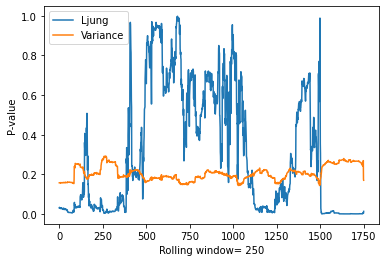

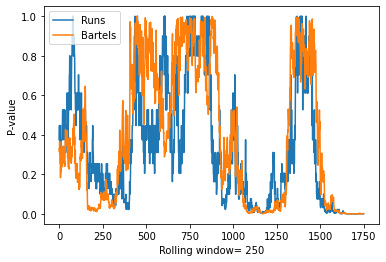

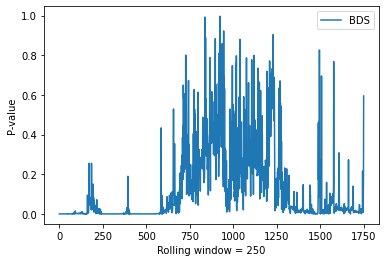

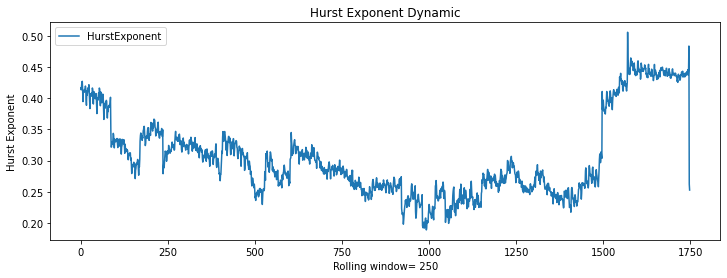

-------------------------------------
COINBASE_BTC


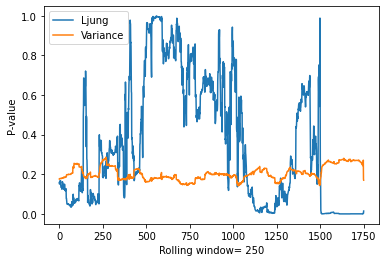

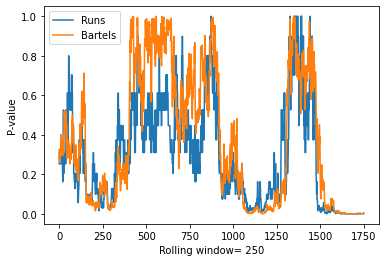

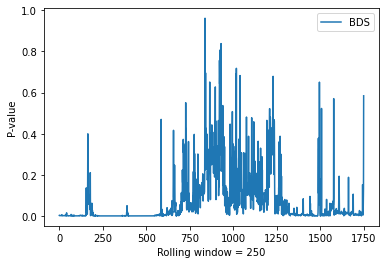

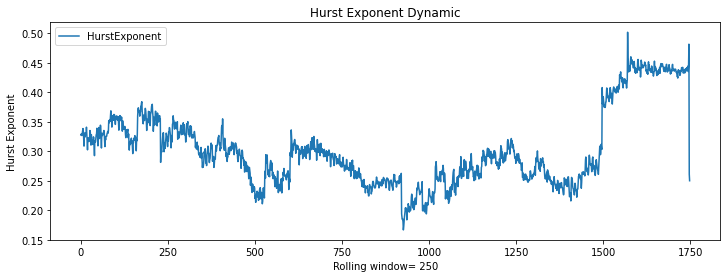

-------------------------------------
COINBASE_ETH


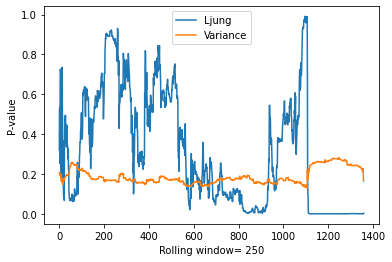

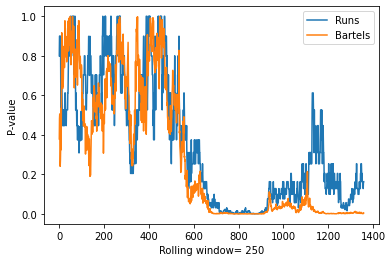

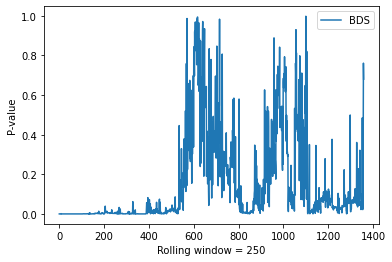

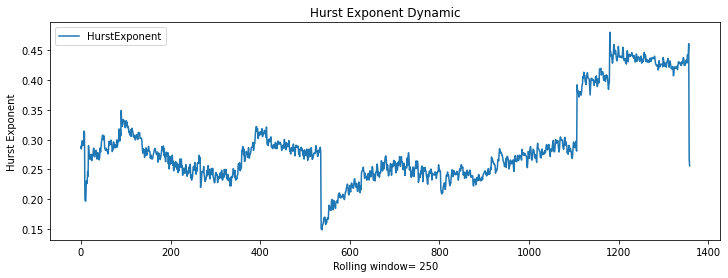

-------------------------------------
BITFINEX_ETH


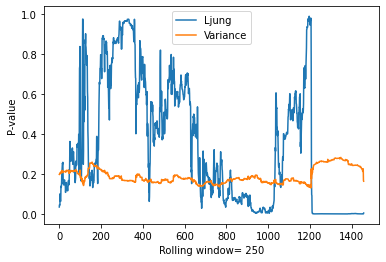

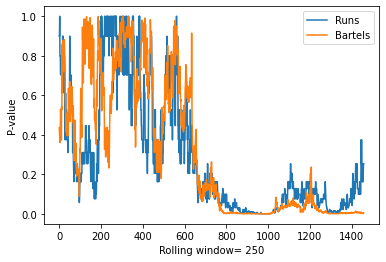

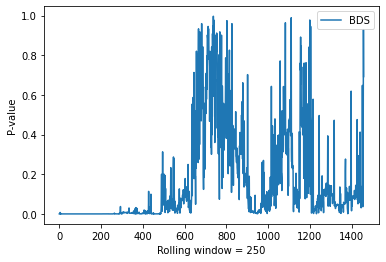

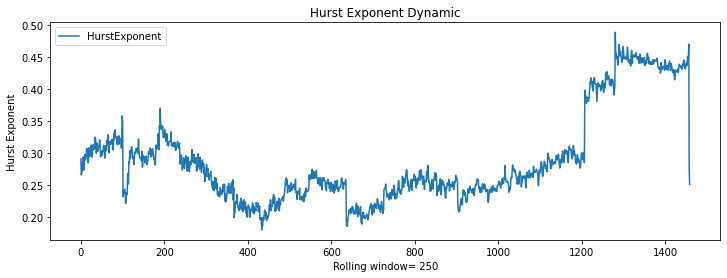

-------------------------------------
BITFINEX_XRP


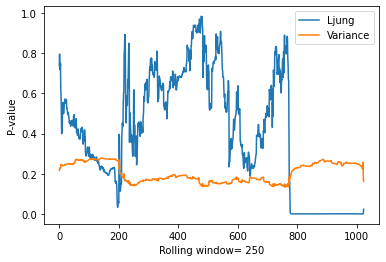

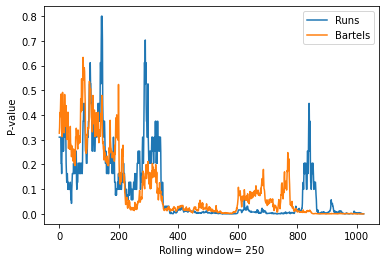

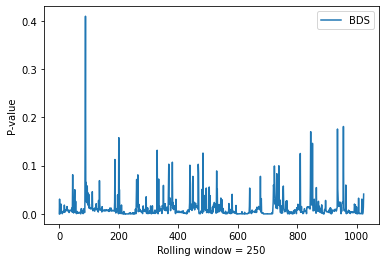

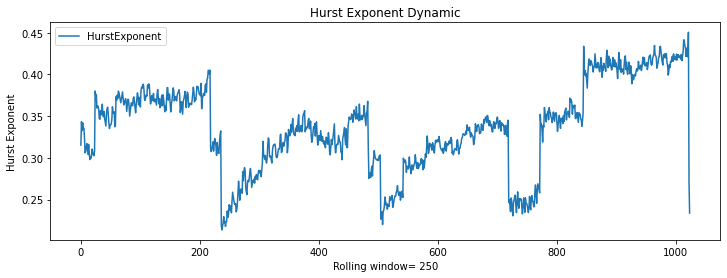

-------------------------------------
BITSTAMP_XRP


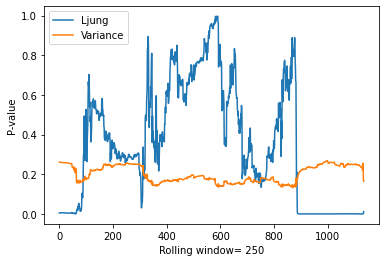

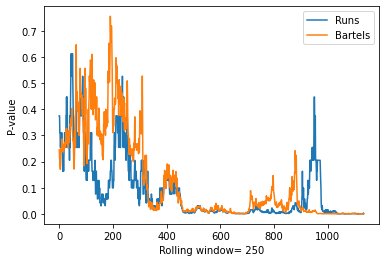

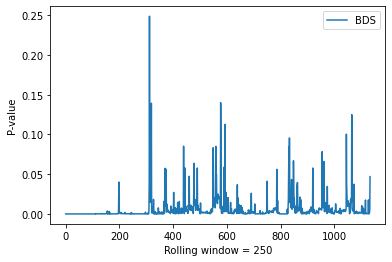

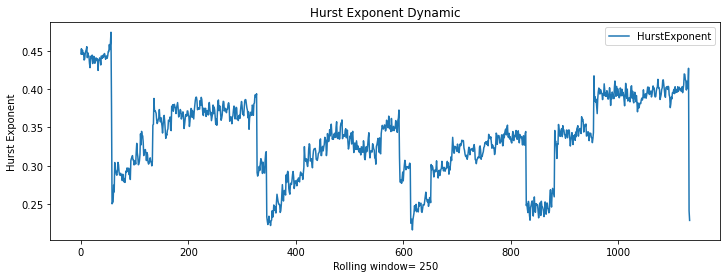

-------------------------------------
BITFINEX_BCH


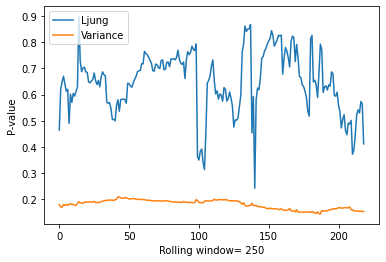

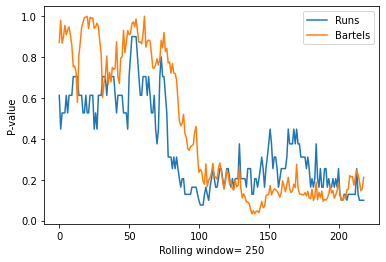

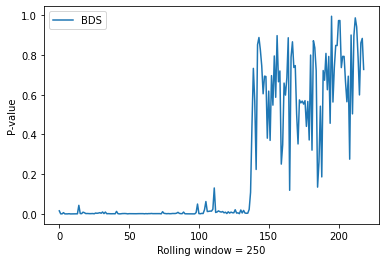

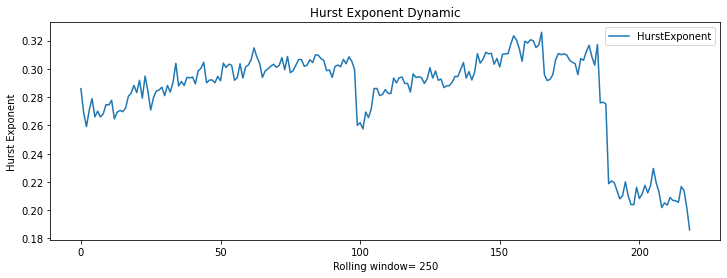

-------------------------------------
COINBASE_BCH


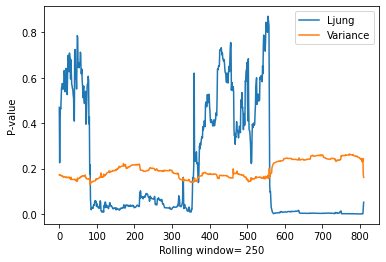

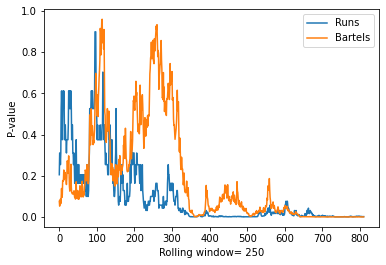

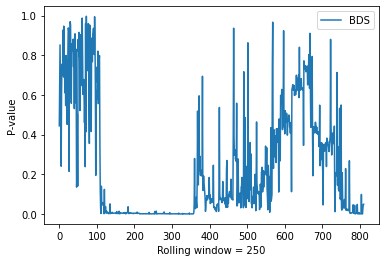

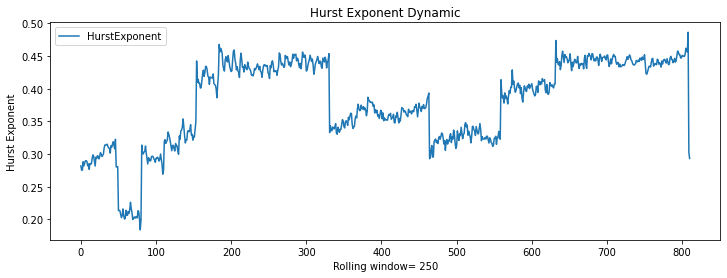

-------------------------------------
BITFINEX_EOS


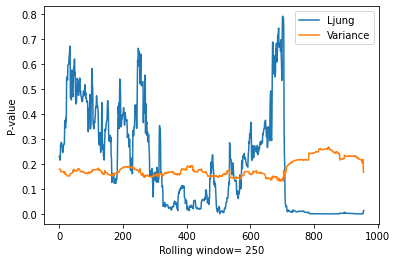

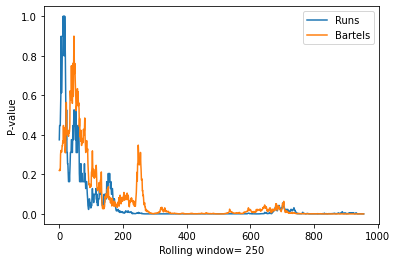

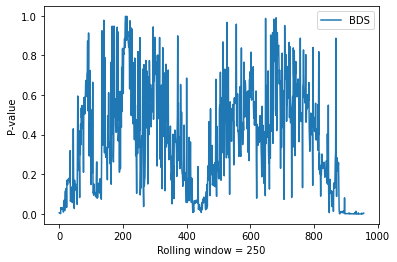

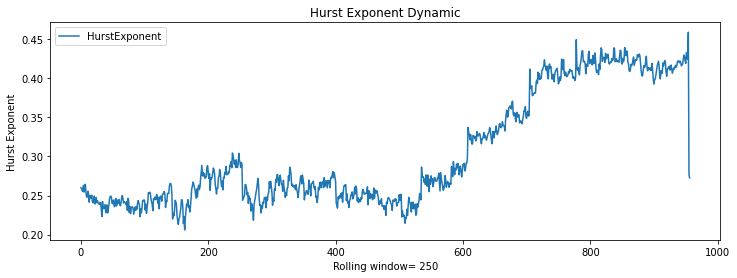

-------------------------------------
KRAKEN_EOS


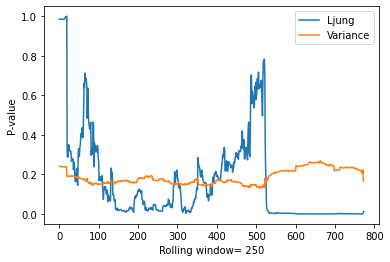

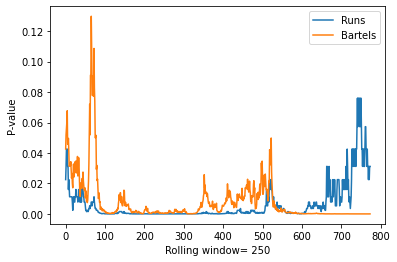

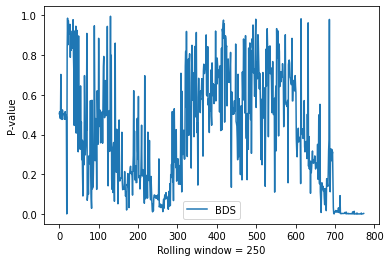

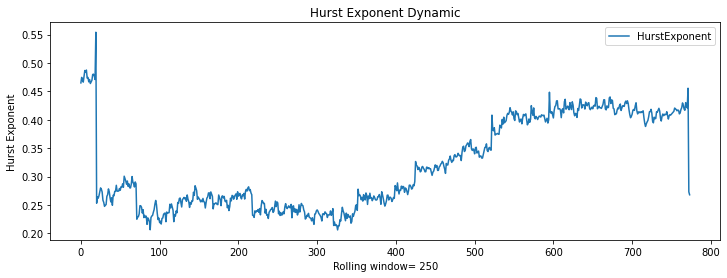

-------------------------------------
COINBASE_LTC


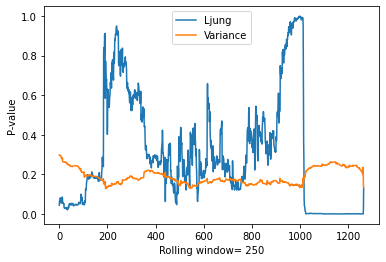

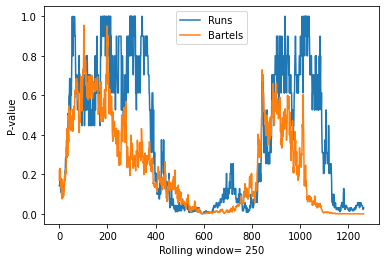

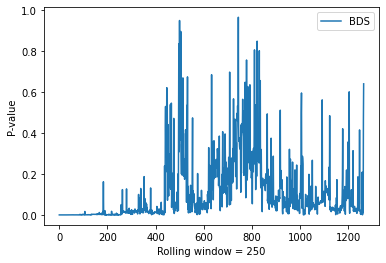

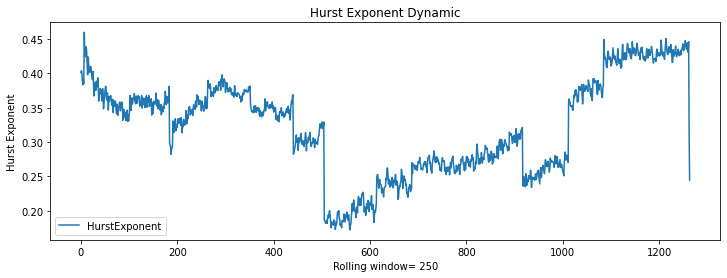

-------------------------------------
BITFINEX_LTC


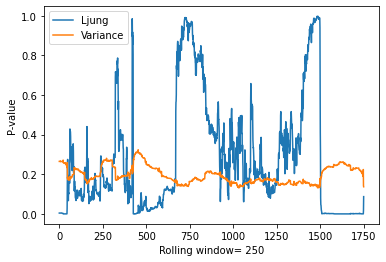

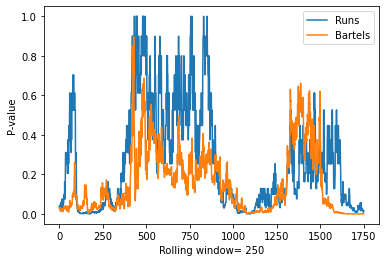

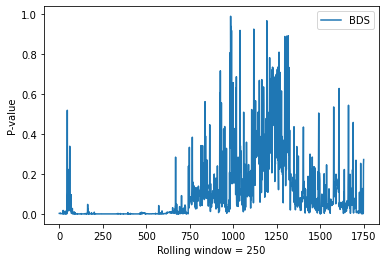

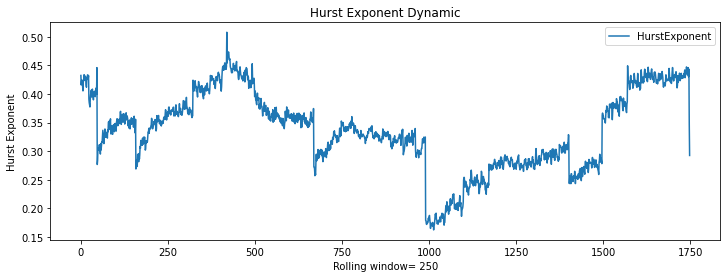

-------------------------------------
KRAKEN_XLM


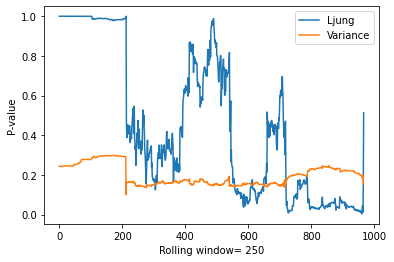

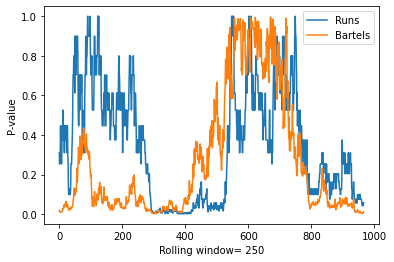

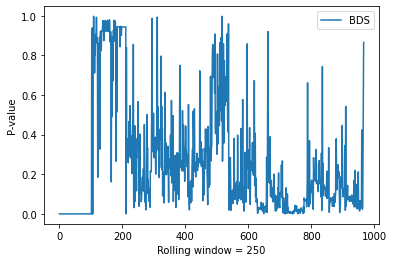

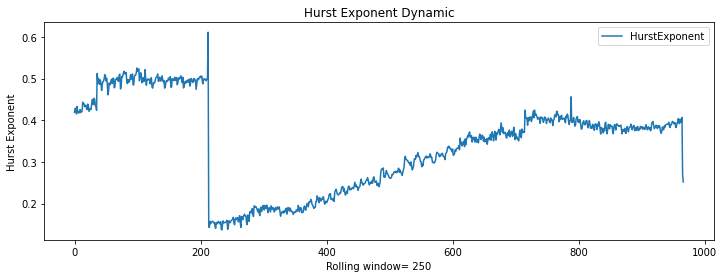

-------------------------------------
CEXIO_XLM


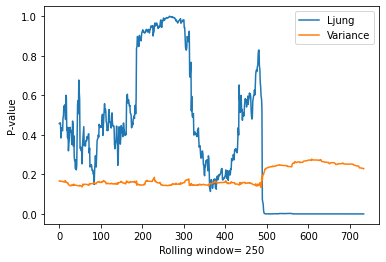

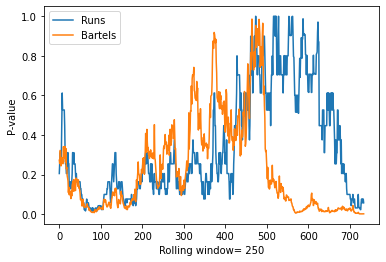

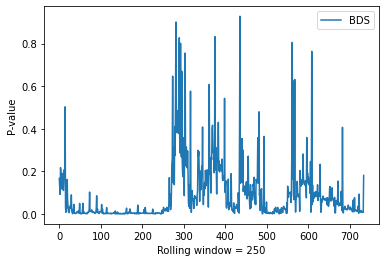

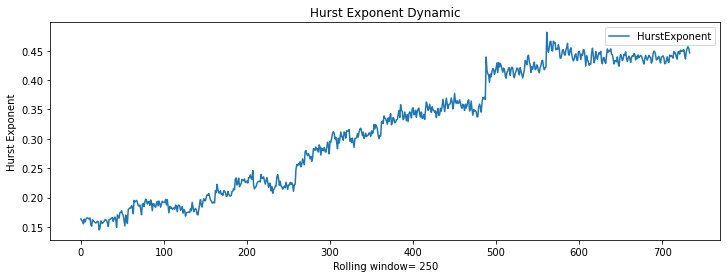

-------------------------------------
BITFINEX_NEO


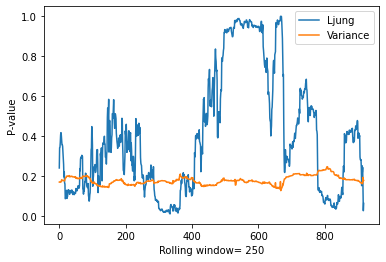

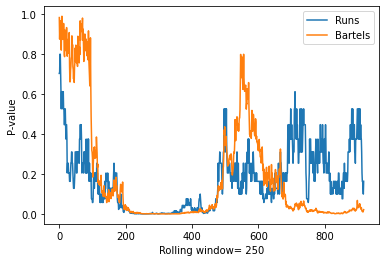

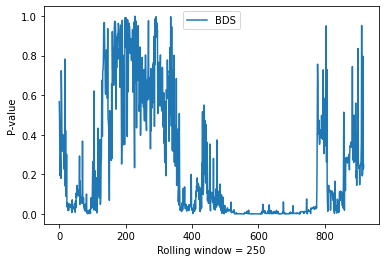

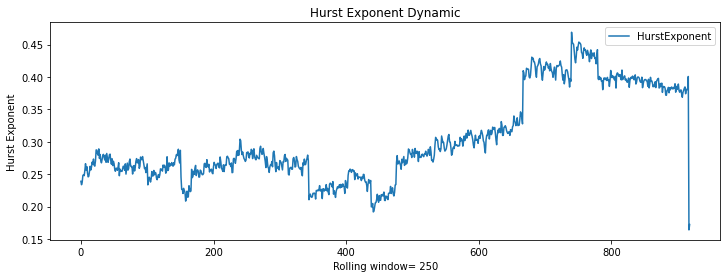

-------------------------------------
QUOINE_NEO


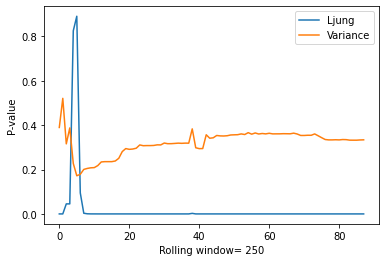

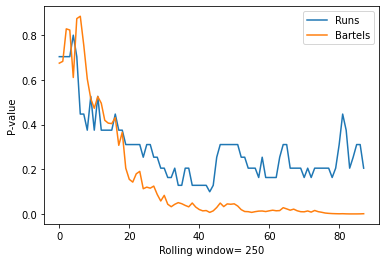

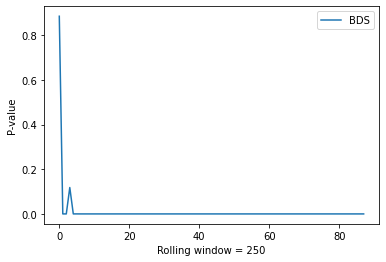

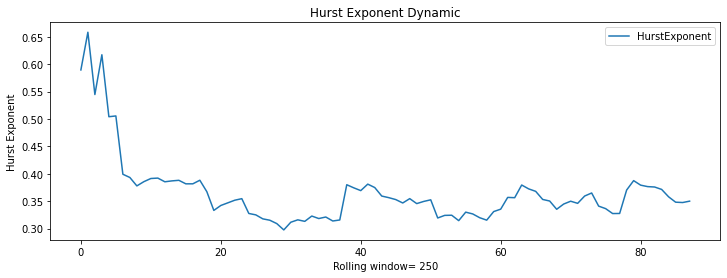

-------------------------------------
BITFINEX_XMR


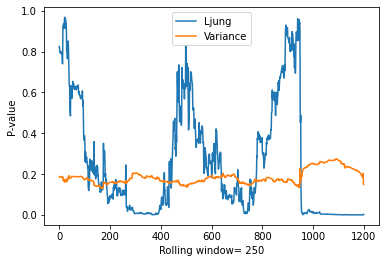

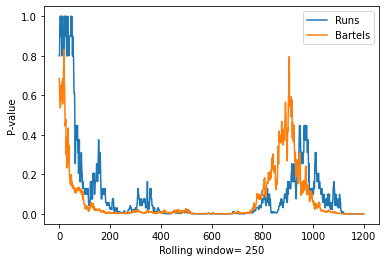

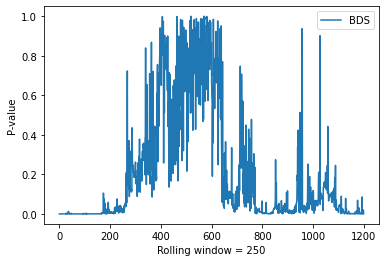

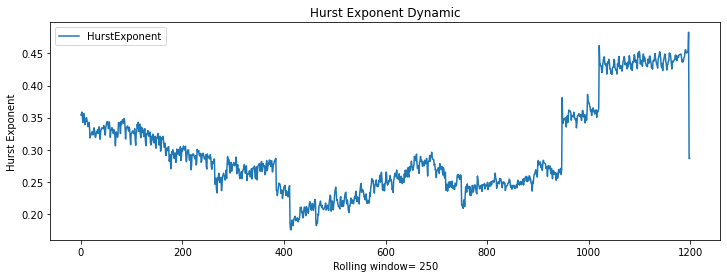

-------------------------------------
KRAKEN_XMR


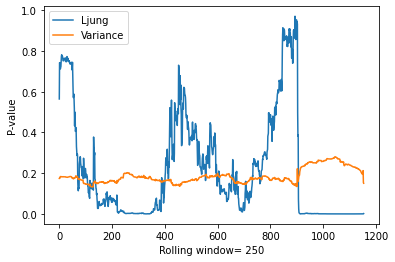

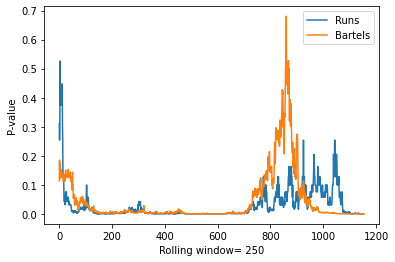

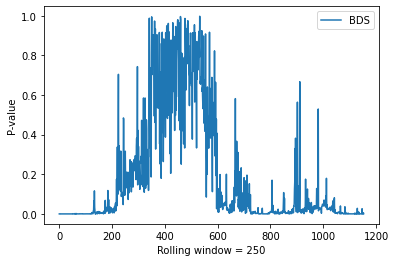

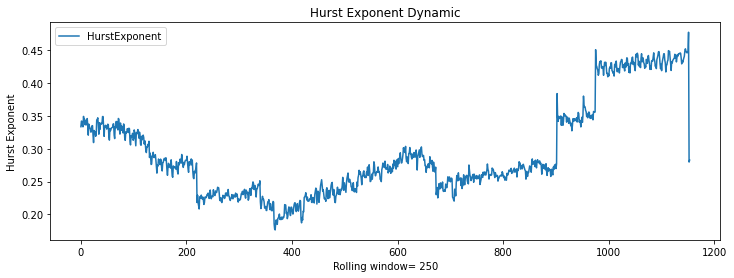

-------------------------------------
BITFINEX_DASH


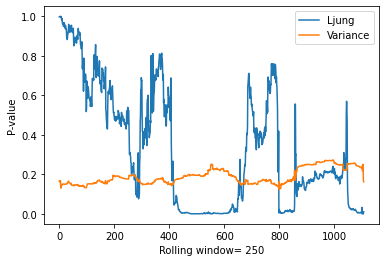

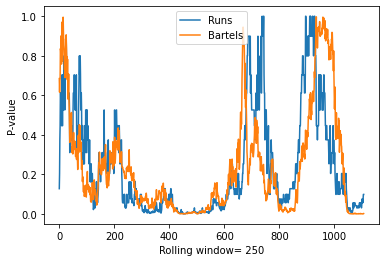

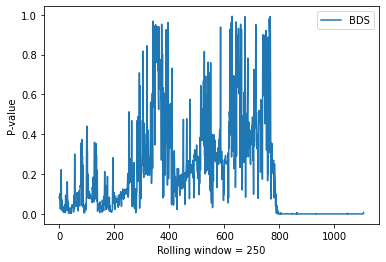

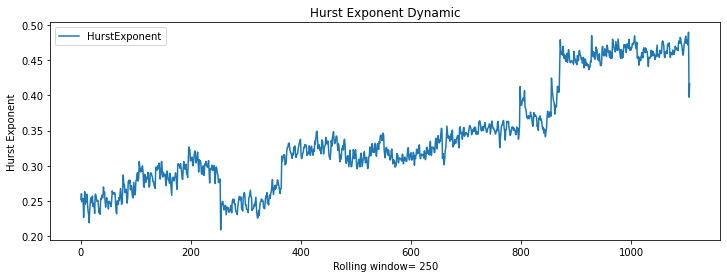

-------------------------------------
EXMO_DASH


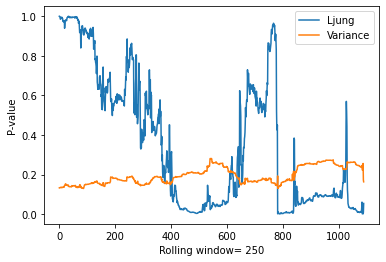

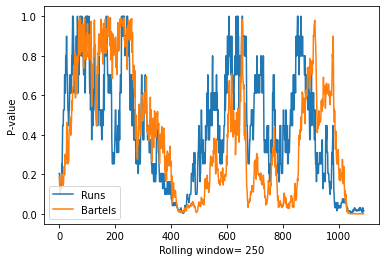

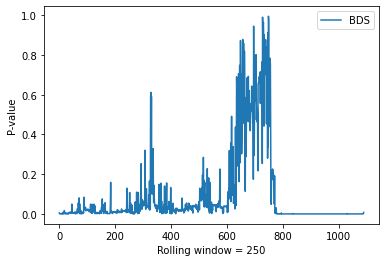

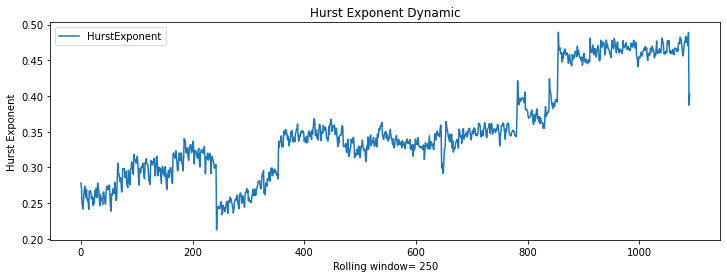

-------------------------------------
YOBIT_XEM


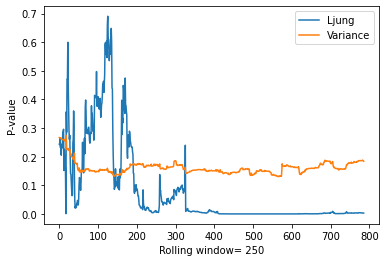

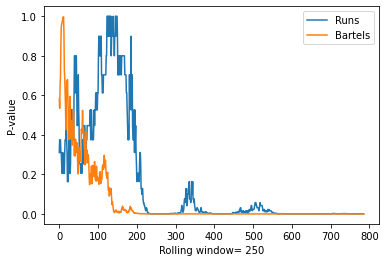

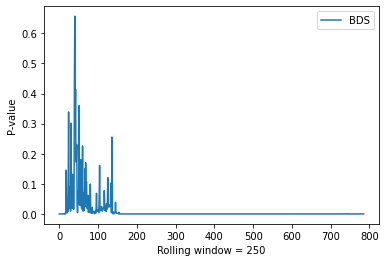

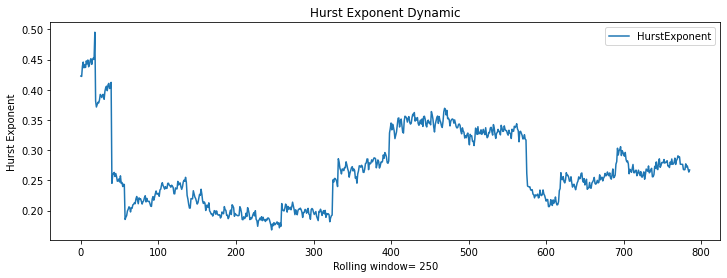

-------------------------------------
LIVECOIN_XEM


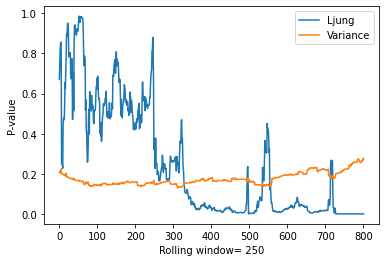

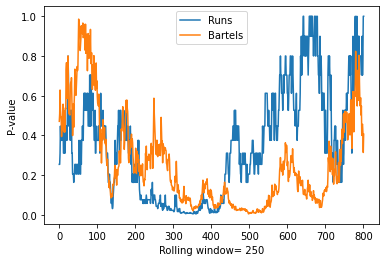

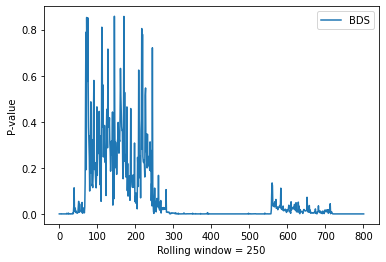

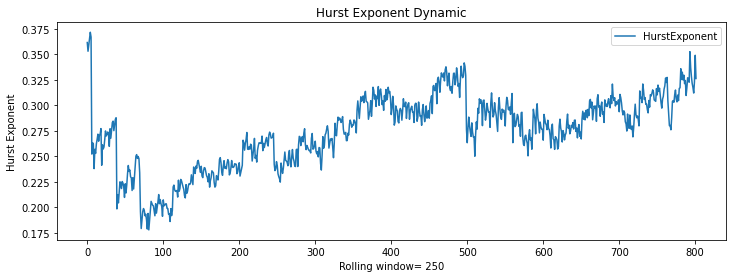

-------------------------------------
BITFINEX_TRX


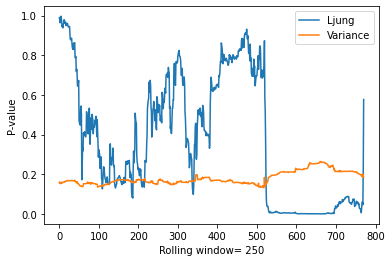

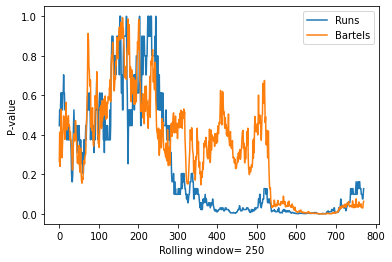

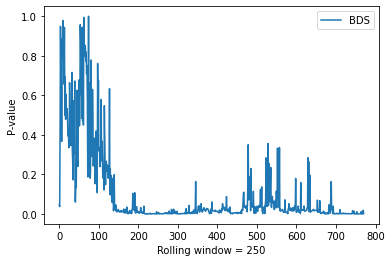

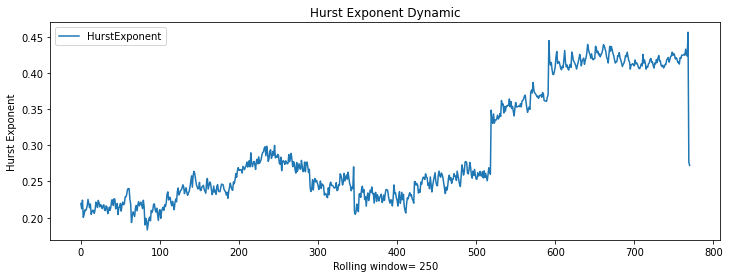

-------------------------------------
YOBIT_TRX


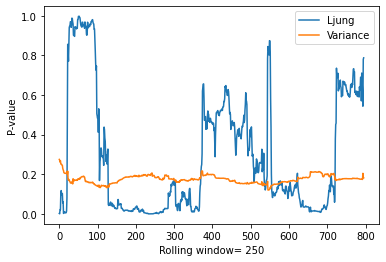

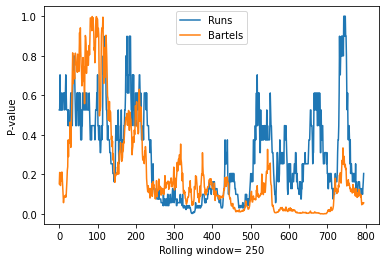

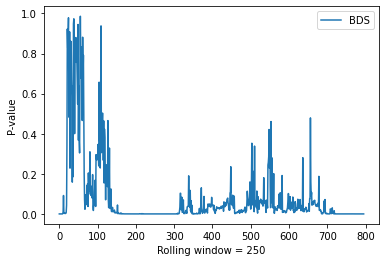

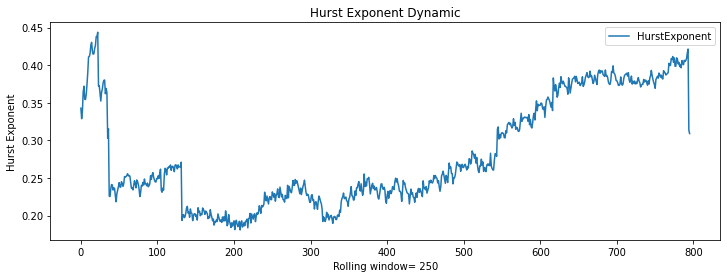

-------------------------------------
KRAKENT


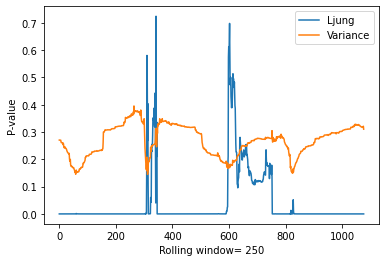

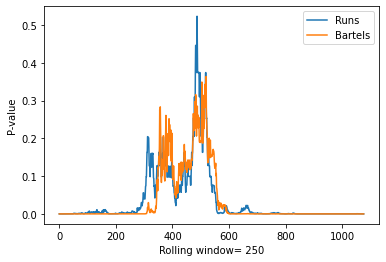

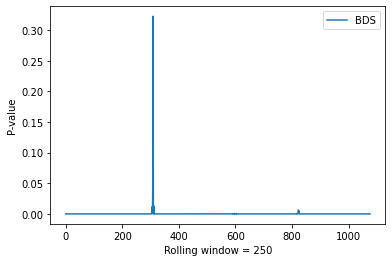

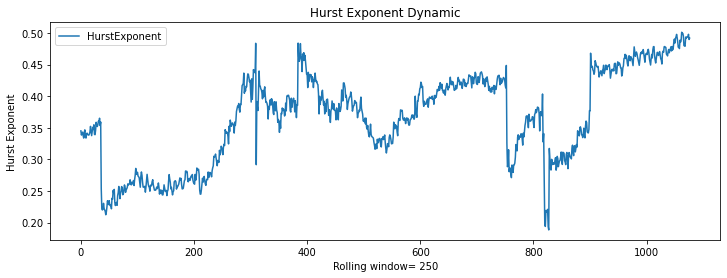

-------------------------------------
EXMOT


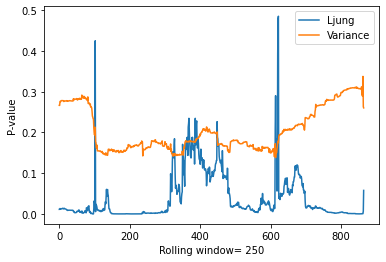

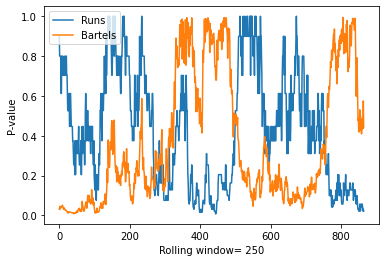

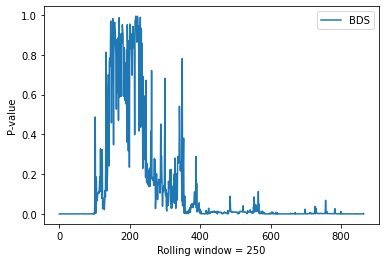

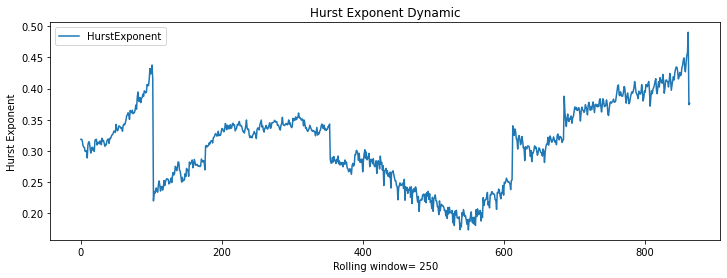

-------------------------------------
KRAKEN_ETC


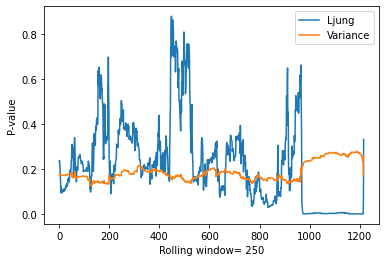

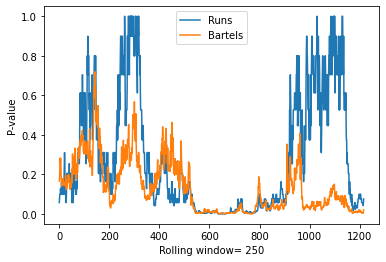

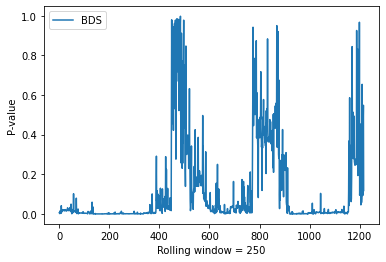

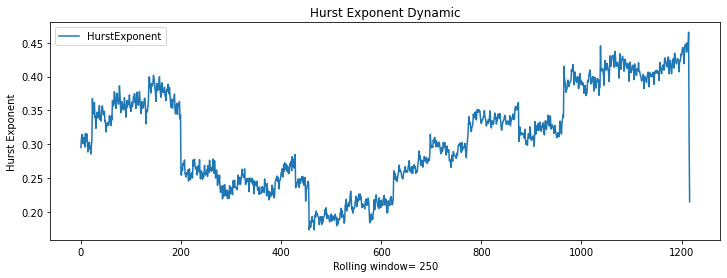

-------------------------------------
BITFINEX_QTUM


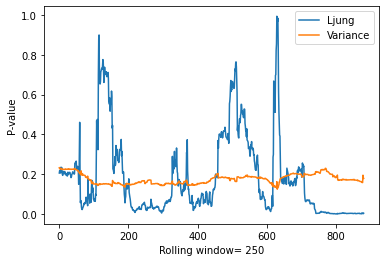

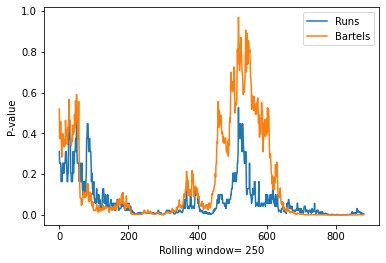

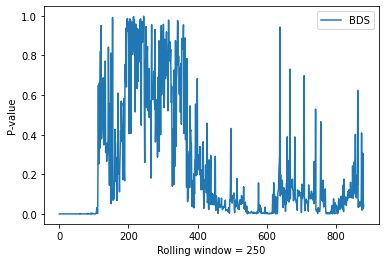

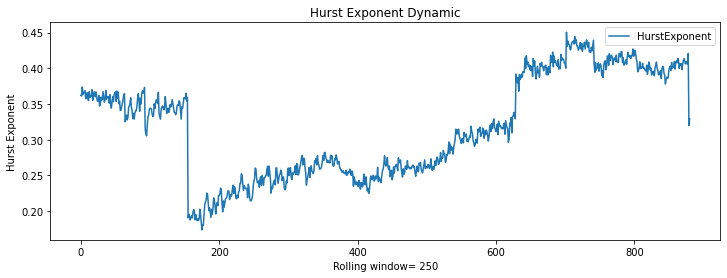

-------------------------------------
BITFINEX_OMG


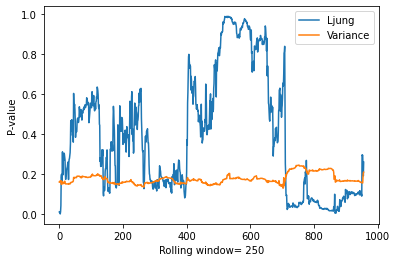

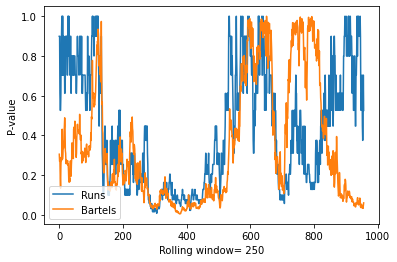

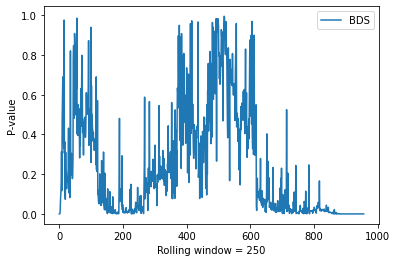

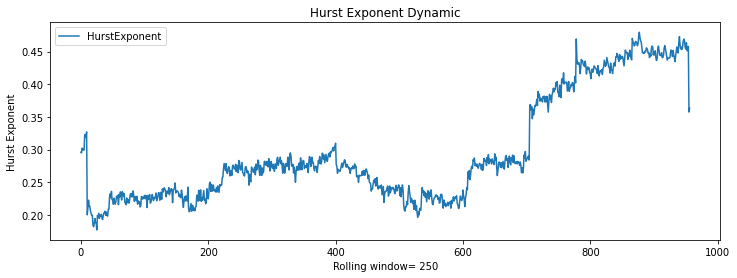

-------------------------------------
YOBIT_LSK


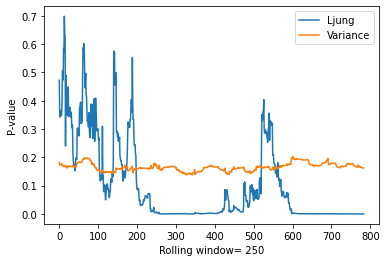

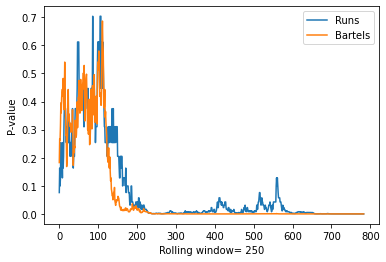

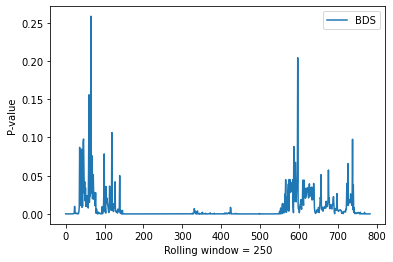

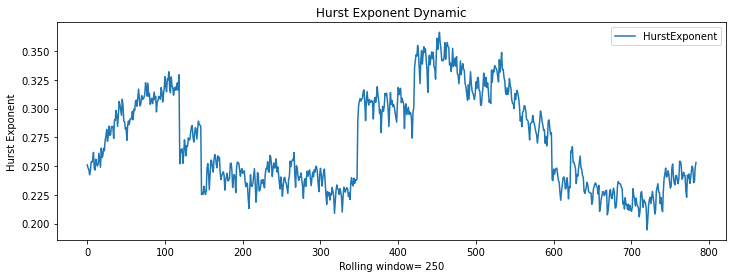

-------------------------------------
LIVECOIN_LSK


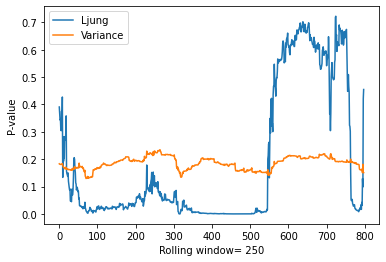

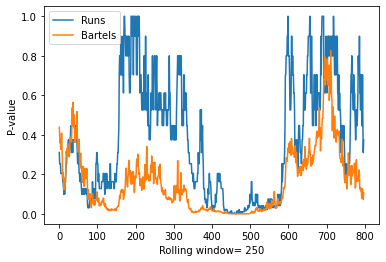

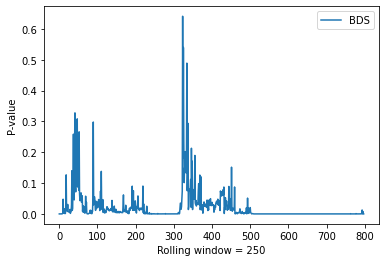

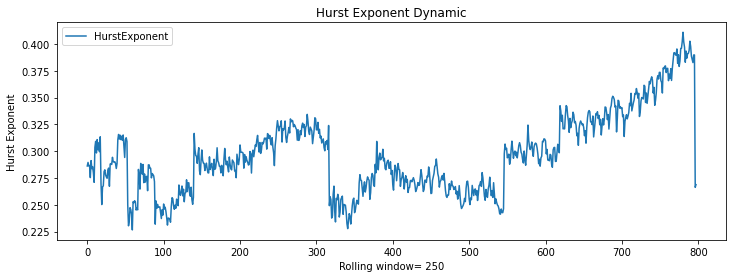

-------------------------------------
YOBIT_BTG


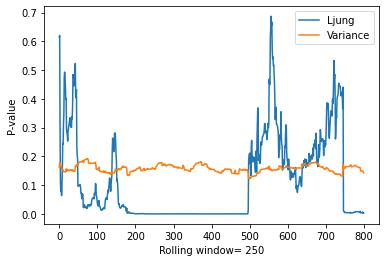

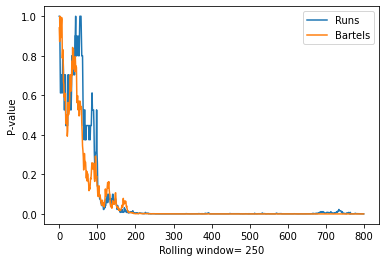

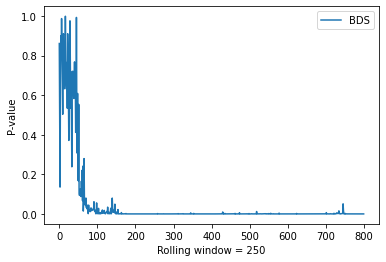

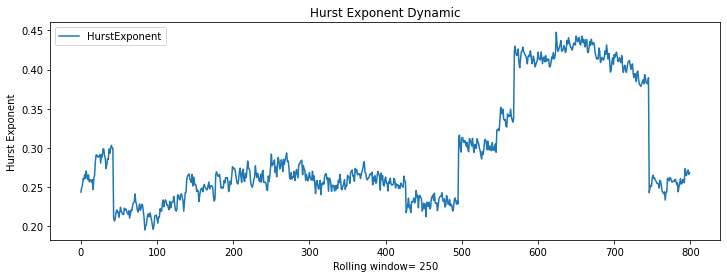

-------------------------------------


In [55]:
df_daily= pd.ExcelFile('/Users/Catalina/Desktop/Cod_BTC/DateCrypto.xlsx')

AllTables(df_daily, 250,'DailypValuesCrypto.xlsx', 2)